Implements algorithm 3 (ModMod) from Algorithms for "Approx Min of the Difference Between Submodular Fncs with Applications."

For prob_ssm

In [3]:
import torch
from torch import distributions as dist

import itertools
import pickle
import operator
import importlib

import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 25})
plt.rcParams.update({'xtick.labelsize': 25})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models

import helpers, opt, bases

In [4]:
with open('../inputs/phoq.pkl', 'rb') as f:
    t = pickle.load(f)

X = t[0] # one-hot encoding of X
T = t[1] # tokenized encoding of X
y = t[2].values

In [5]:
wt = helpers.decode_X(X[150614])  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'

In [6]:
seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i

In [14]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
train_seqs = [wt] + singles
train_inds = [seq_to_x[seq] for seq in train_seqs]
np.random.seed(100)
train_inds = list(np.random.choice(len(X), 100, replace=True)) # generate random indices for 100 X's to sample from

X_train = X[train_inds]
y_train = y[train_inds]
X_test = X
y_true = y

In [8]:
ground = [(aa, i) for aa in aas for i in range(4)]

In [9]:
def seqs_from_set(chosen, L):
    pos = [[c[0] for c in chosen if c[1] == p] for p in range(L)]
    return [''.join(s) for s in itertools.product(*pos)]

In [15]:
helpers = importlib.reload(helpers)
opt = importlib.reload(opt)

n_start = 35
max_its = 30
rounds = 4
L = 4
n = 100

observed_inds = [train_inds]
X_sampled = [X[train_inds]]
y_sampled = [y[train_inds]]


libraries = []
histories = []

for rou in range(rounds):
    print('Round %d' %rou)
    inds = sorted(set(itertools.chain(*observed_inds)))
    dic, _ = helpers.get_predictions(X[inds], y[inds], X_test, its=500)
    print()
    seed = helpers.get_seed(dic)
    chosen, obj = bases.greedy(dic, seed, n, L)
    libraries.append(chosen)
    histories.append(obj)
    seqs = seqs_from_set(chosen, L)
    inds = np.random.choice(len(seqs), n, replace=True)
    sampled_seqs = [seqs[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    X_sampled.append(X[inds])
    y_sampled.append(y[inds])
    observed_inds.append(inds)
    
    

Round 0
Iteration 500 of 500	NLML: 39.7080	sn: 0.165770	
Round 1
Iteration 500 of 500	NLML: 3.9694	sn: 0.487985		
Round 2
Iteration 500 of 500	NLML: -6.7064	sn: 0.481202	
Round 3
Iteration 500 of 500	NLML: -130.8499	sn: 0.011864	


In [ ]:
libraries

In [ ]:
histories

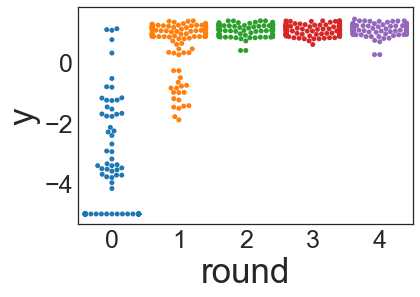

In [17]:
df = pd.DataFrame(np.concatenate(y_sampled), columns=['y'])
df['round'] = [0] * (n) + [1] * n + [2] * n + [3] * n + [4] * n
_ = sns.swarmplot(data=df, x='round', y='y')

In [18]:
[max(yy) for yy in y_sampled]

[1.1320769257975296,
 1.3929903785945754,
 1.3929903785945754,
 1.3929903785945754,
 1.4505212684956694]

In [19]:
[opt.get_N(lib, L) for lib in libraries]

[168, 108, 108, 192]

In [21]:
df.to_csv('../outputs/greedy_phoq.txt', index=False)